# Applying Finite DMRG to Kitaev Ladder Model

In this notebook, we will begin our trial of finite DMRG on Kitaev ladders.

Firstly, we will carry a demo copied from the official examples, and checked the following conclusion using Ising model:

 - the typical distribution of entanglement over unit cells of a gapped state
 - the typical distribution of entanglement over unit cells of a gapless state
 
Secondly, we will carry the finite DMRG over a confirmed gapless state of Kitaev ladder, the double Kitaev string `J = (1, 1, 0)`, and a confirmed gapped state, `(a, b) = (.75, .5)`;
 


## The demo usage of finite DMRG in TeNPy

In [26]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg.eigen.arpack as arp
import warnings
import scipy.integrate

from matplotlib.pyplot import *
from scipy.optimize import curve_fit, leastsq

In [2]:
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.models.spins import SpinModel
from tenpy.algorithms import dmrg

In [50]:
from numpy import pi
from kitaev_ladder import KitaevLadderModel, load_data, run_atomic, save_after_run
from rotation import get_xyz, decimals
# path toolkits
from pathlib import Path

ImportError: cannot import name 'load_data' from 'kitaev_ladder' (/home/jerry/Downloads/KitaevLadder/kitaev_ladder.py)

In [3]:
def finite_gs_energy(L, J, g):
    """For comparison: obtain ground state energy from exact diagonalization.
    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_xx = sparse.csr_matrix((2**L, 2**L))
    H_z = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_xx = H_xx + sx_list[i] * sx_list[(i + 1) % L]
    for i in range(L):
        H_z = H_z + sz_list[i]
    H = -J * H_xx - g * H_z
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return E[0]


In [4]:
def example_DMRG_tf_ising_finite(L, g, verbose=True):
    print("finite DMRG, transverse field Ising model")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    model_params = dict(L=L, J=1., g=g, bc_MPS='finite', conserve=None, verbose=verbose)
    M = TFIChain(model_params)
    product_state = ["up"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': None,  # setting this to True helps to escape local minima
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 30,
            'svd_min': 1.e-10
        },
        'verbose': verbose,
        'combine': True
    }
    info = dmrg.run(psi, M, dmrg_params)  # the main work...
    E = info['E']
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
    mag_x = np.sum(psi.expectation_value("Sigmax"))
    mag_z = np.sum(psi.expectation_value("Sigmaz"))
    print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    if L < 20:  # compare to exact result
#         from tfi_exact import finite_gs_energy
        E_exact = finite_gs_energy(L, 1., g)
        print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))
        print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, M

## The gapless Ising

In [5]:
E, psi, M = example_DMRG_tf_ising_finite(L=10, g=1., verbose=True)

finite DMRG, transverse field Ising model
L=10, g=1.00
Reading 'bc_MPS'='finite' for config TFIChain
Reading 'conserve'=None for config TFIChain
Reading 'L'=10 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=1.0 for config TFIChain
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=None for config DMRG
sweep 10, age = 10
Energy = -12.3814899996547751, S = 0.3370841145840079, norm_err = 6.4e-15
Current memory usage 105.2 MB, time elapsed: 1.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 9.8706e-21, max_E_trunc = 1.4211e-14
MPS bond dimensions: [2, 4, 8, 14, 19, 14, 8, 4, 2]
sweep 20, age = 10
Energy = -12.3814899996547663, S = 0.3370841145840076, norm_err = 9.5e-15
Current memory usage 105.2 MB, time elapsed: 2.0 s
Delta E = 8.8818e-16, Delta S = -3.3307e-17 (per sweep)
max_trunc_err = 9.8706e-21, max_E_trunc = 5.3291e-15
MPS bond d

In [6]:
entanglement_entropy = psi.entanglement_entropy()
entanglement_spectrum = psi.entanglement_spectrum()

In [7]:
entanglement_entropy

array([0.26485952, 0.32877245, 0.35930702, 0.37441333, 0.37905241,
       0.37441333, 0.35930702, 0.32877245, 0.26485952])

In [8]:
entanglement_spectrum

[array([0.07730669, 2.59837909]),
 array([ 0.10648949,  2.29439336,  8.659313  , 10.84721688]),
 array([ 0.1217556 ,  2.17009021,  7.78873602,  9.83707063, 15.82878799,
        17.8771226 , 23.49576841, 25.54410302]),
 array([ 0.12957971,  2.11313206,  7.42800359,  9.41155593, 14.72907782,
        16.71263016, 22.02750169, 24.01105404, 24.29541742, 26.27896976,
        31.5938418 , 33.57739581, 38.89494311, 40.87936836]),
 array([ 0.1320149 ,  2.09622416,  7.32434428,  9.28855354, 14.4364347 ,
        16.40064396, 21.62876408, 23.54650688, 23.59297335, 25.51071614,
        30.73883633, 32.70304675, 35.46322309, 37.42743313, 37.85093981,
        39.81532374, 42.65595721, 44.62018793, 45.03992791]),
 array([ 0.12957971,  2.11313206,  7.42800359,  9.41155593, 14.72907782,
        16.71263016, 22.02750169, 24.01105404, 24.29541742, 26.27896976,
        31.59384183, 33.57739584, 38.89494387, 40.87936845]),
 array([ 0.1217556 ,  2.17009021,  7.78873602,  9.83707063, 15.82878799,
        17.8

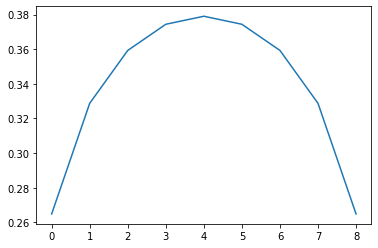

In [11]:
plot(entanglement_entropy)

In [45]:
L = 100
E, psi, M = example_DMRG_tf_ising_finite(L=L, g=1., verbose=True)
entanglement_entropy = psi.entanglement_entropy()

finite DMRG, transverse field Ising model
L=100, g=1.00
Reading 'bc_MPS'='finite' for config TFIChain
Reading 'conserve'=None for config TFIChain
Reading 'L'=100 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=1.0 for config TFIChain
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=None for config DMRG
sweep 10, age = 100
Energy = -126.9618767395063657, S = 0.5277993943516751, norm_err = 9.6e-10
Current memory usage 293.1 MB, time elapsed: 21.3 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 6.7100e-13, max_E_trunc = 5.1301e-12
MPS bond dimensions: [2, 4, 8, 16, 22, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

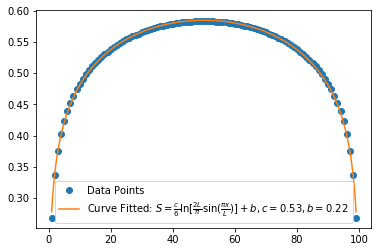

In [47]:
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()


## Gapped Ising

In [48]:
L = 100
g = .5
E, psi, M = example_DMRG_tf_ising_finite(L=L, g=g, verbose=True)
entanglement_entropy = psi.entanglement_entropy()

finite DMRG, transverse field Ising model
L=100, g=0.50
Reading 'bc_MPS'='finite' for config TFIChain
Reading 'conserve'=None for config TFIChain
Reading 'L'=100 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=0.5 for config TFIChain
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=None for config DMRG
sweep 10, age = 100
Energy = -105.4837699496445680, S = 0.0035607045280003, norm_err = 1.0e-13
Current memory usage 303.2 MB, time elapsed: 12.5 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.2456e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [2, 4, 8, 11, 12, 13, 14, 13, 13, 12, 12, 12, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

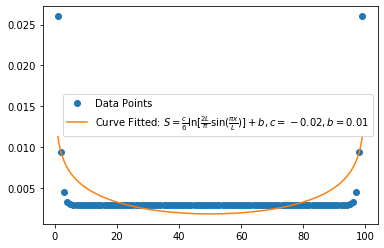

In [49]:
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()


Now we basically know how to carry the finite DMRG on Ising model.

Let's do something over our Kitaev ladders!

## Kitaev Ladder